## This is the Ekman composite Figure + the time series

### Prepare Ekman Composite 

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [3]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33279/status,
Dashboard: /proxy/33279/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42715,Workers: 7
Dashboard: /proxy/33279/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:35669,Total threads: 4
Dashboard: /proxy/33075/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:40955,


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [5]:
lon_slice  = slice(-256, -246) 
lat_slice  = slice(-67, -64)


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians


In [6]:
#pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lon_slice  = slice(-256, -246) 
lat_slice  = slice(-67, -64)


first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

In [7]:
# database for control simulation:
control = '01deg_jra55v13_ryf9091'

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

In [8]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [9]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_con = curl_tauf_con/rho0*s_day


### Climatology 

In [10]:
# calculate monthly climatology
climatology = ekman_con.groupby('time.month').mean('time')

# remove seasonal signal
ekman_con_seasonal_removed = (ekman_con - climatology)

In [11]:
#ekman_con_seasonal_removed

In [12]:
## this helps to check which months are contained on our main data files. 
month=ekman_con['time.month'].values


In [13]:
#load the variable
ekman_con = ekman_con.load()
ekman_con_seasonal_removed = ekman_con_seasonal_removed.load()
##test
#np.amin(temp_400m_za)

#### Here's a step-by-step explanation of what's happening in the code:

#### ekman_con has the dimensions (time=732, y=100, x=100).
#### climatology is calculated by taking the mean of ekman_con along the time dimension for each month. This results in climatology having dimensions (month=12, y=100, x=100).
#### climatology is then broadcasted to match the shape of ekman_con along the time dimension, so that it now has dimensions (time=732, month=12, y=100, x=100).
#### The broadcasted climatology is then subtracted from ekman_con, resulting in ekman_con_seasonal_removed having dimensions (time=732, month=12, y=100, x=100). This means that the month dimension is preserved in the result.

#### Because of that, we can probably remove the month dimension to not cause issues later on.

In [14]:
# select a single month and drop the 'month' dimension
ekman_con_seasonal_removed = ekman_con_seasonal_removed.isel(month=0).drop('month')

### I didn't notice significant difference from the plot, so I will test if the values were different at all:

In [15]:
# calculate absolute difference between ekman_con and ekman_con_seasonal_removed
diff = np.abs(ekman_con - ekman_con_seasonal_removed)

# check if the absolute difference is zero or not
if np.all(diff == 0):
    print("ekman_con and ekman_con_seasonal_removed are identical")
else:
    print("ekman_con and ekman_con_seasonal_removed are different")

ekman_con and ekman_con_seasonal_removed are different


### Apparently they are, so my procedure should have worked. I will try detrending and rolling a 12 month mean through the new data

### First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [16]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [17]:
# Note we need to first detrend the data:
#ekman_con_detrended = detrend_dim(ekman_con_seasonal_removed,'time') #commented out because if we run this line the average panel is 0. 
ekman_con_dr = ekman_con_seasonal_removed.rolling(time=12, center=True).mean()

### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [18]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [19]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

In [20]:
#try running this line. If it doesn't fix the problem, try running without it.
#ekman_roll=ekman_con
ekman_roll=ekman_con_dr
#ekman_roll=ekman_con_dr.shift(time=-2).dropna(dim='time')


In [21]:
## because bt_id has high indexes we need to get rid off them. This data is no longer existent if we shift ekman back 8, 9,10 months / ekman_roll now has time 727
bt_6=bt_id[:-2]

## because bt_id has high indexes we need to get rid off them. This data is no longer existent if we shift ekman back 6, 6a and 7 months / ekman_roll now has time 727
#bt_6=bt_id[:-3]

## because bt_id has high indexes we need to get rid off them. This data is no longer existent if we shift ekman back 4 months / ekman_roll now has time 727
#bt_6=bt_id[:-1]

### creating the averages for peaks and lows

In [22]:
#full mean
ekman_con_avg = ekman_roll.mean('time')
ekman_con_avg = ekman_con_avg.load()

#mean of all high peaks together
ekman_high_avg=ekman_roll[top_id].mean('time')
ekman_high_avg = ekman_high_avg.load()

#mean of all low peaks together
ekman_low_avg=ekman_roll[bt_6].mean('time')
ekman_low_avg = ekman_low_avg.load()

## PLOT COMPOSITES FOR EKMAN

In [23]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [24]:
# import bathymetry and the land/ocean mask to add to plot:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(hu.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

#### lag 0
#### lag 2
#### lag 4
#### lag 6

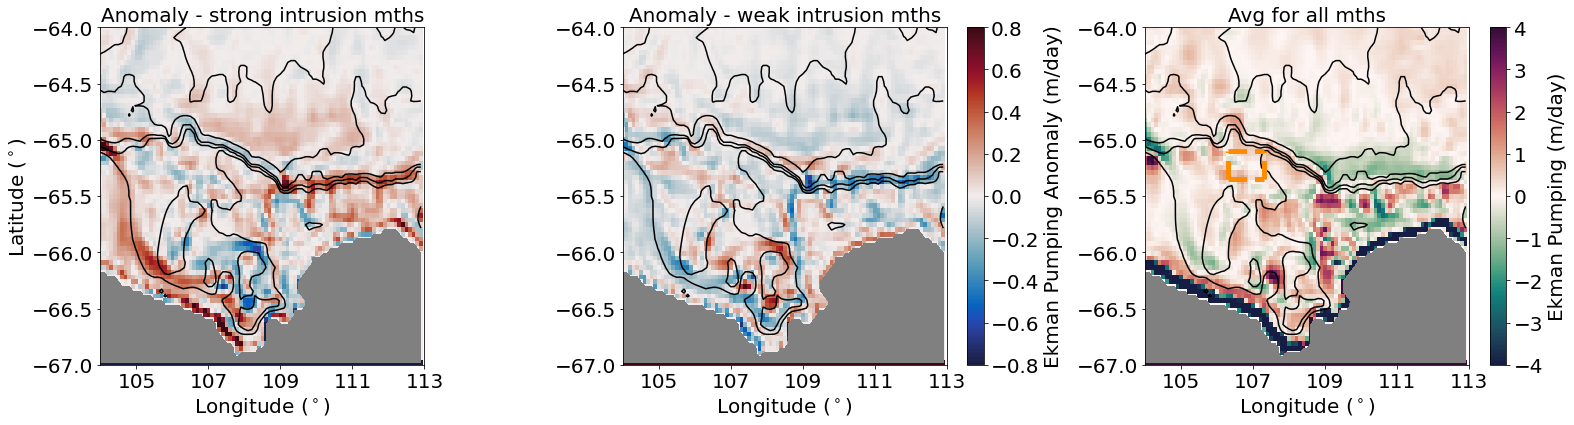

In [31]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = ekman_high_avg-ekman_con_avg;
t_low = ekman_low_avg-ekman_con_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
plt.title('Anomaly - strong intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,1000],colors='darkorange',linewidth=1)
# plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
fig.delaxes(fig.axes[1])
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#plt.plot([-250.5,-250.5],[-65.65, -65.2],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-249.5,-249.5],[-65.65, -65.2],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-250.5,-249.5],[-65.2, -65.2],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-250.5,-249.5],[-65.65, -65.65],color='blueviolet',linestyle='--',linewidth=5)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='magenta',linestyle='--',linewidth=4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly - weak intrusion mths',fontsize=fontsize)
#plt.title('Anomaly for falling Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,1000],colors='darkorange',linewidth=1)
# plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman Pumping Anomaly (m/day)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(ekman_con_avg.xu_ocean,ekman_con_avg.yu_ocean,
                        ekman_con_avg, cmap = cmocean.curl, 
                        vmin=-4,vmax=4)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=5)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=5)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,1000],colors='darkorange',linewidth=1)
# plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman Pumping (m/day)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)


fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/fig6a_composite_ekman.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')



### LOAD SPECIAL CONTOURS

In [24]:
# cut the data BOX 1
lon_slice  = slice(-253, -251.5) #isopycnal contour
lat_slice  = slice(-67, -63)

# topography data:
ht2 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht2 = ht2.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask2 = np.squeeze(ht2.values)*0
land_mask2[np.isnan(land_mask2)] = 1
land_mask2 = np.where(land_mask2==1,land_mask2,np.nan)

fontsize=16

In [25]:
# cut the data BOX 1
lon_slice  = slice(-251, -246) #ekman contour
lat_slice  = slice(-67, -63)

# topography data:
ht3 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht3 = ht3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask3 = np.squeeze(ht2.values)*0
land_mask3[np.isnan(land_mask3)] = 1
land_mask3 = np.where(land_mask3==1,land_mask3,np.nan)

fontsize=16


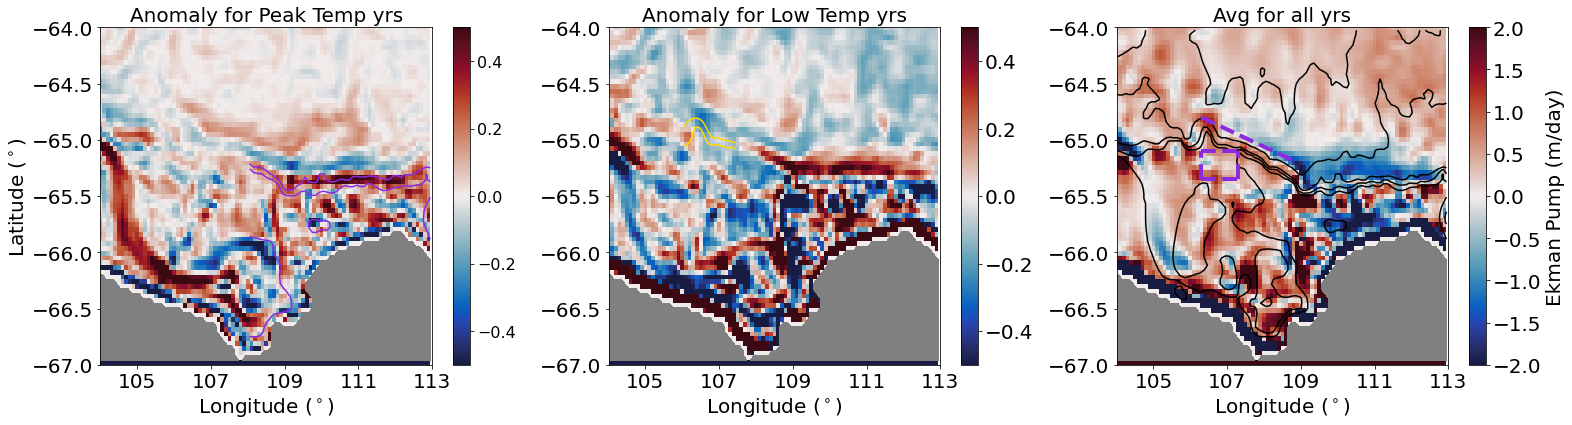

In [50]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = ekman_high_avg-ekman_con_avg;
t_low = ekman_low_avg-ekman_con_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
plt.title('Anomaly for Peak Temp yrs',fontsize=fontsize)
        #plot contours
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contour(ht3.xt_ocean,ht3.yt_ocean,ht3,levels=[500,1000],colors='blueviolet',linewidth=1)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.tick_params(labelsize=16)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='magenta',linestyle='--',linewidth=4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for Low Temp yrs',fontsize=fontsize)
#plt.title('Anomaly for falling Temp yrs',fontsize=fontsize)
        #plot contours
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contour(ht2.xt_ocean,ht2.yt_ocean,ht2,levels=[1000,2000],colors='gold',linewidth=2.5)
#plt.plot([-250,-247],[-65,-65],'--')
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(ekman_con_avg.xu_ocean,ekman_con_avg.yu_ocean,
                        ekman_con_avg, cmap = cmocean.balance, 
                        vmin=-2,vmax=2)
plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=4)
#
plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman Pump (m/day)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)


fig.tight_layout()
figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/fig6a_composite_ekman_specialcontour.eps'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [51]:
ekman_high_avg.mean()

<xarray.DataArray ()>
array(-0.00537937)

In [52]:
ekman_low_avg.mean()

<xarray.DataArray ()>
array(-0.00507429)

### CALCULATIONS

In [53]:
# cut the data BOX 1
lon_slice  = slice(-255, -247.5)
lat_slice  = slice(-67.5, -63)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

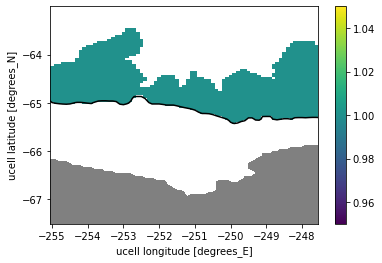

In [54]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U10003000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [55]:
#apply the mask of 1000-3000 MEAN
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.mean('xu_ocean').mean('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.mean('xu_ocean').mean('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-0.01035871975510997
-0.019610976558044082


In [56]:
#apply the mask of 1000-3000 SUM
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.sum('xu_ocean').sum('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.sum('xu_ocean').sum('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

190.89874845174765
162.40097962669782


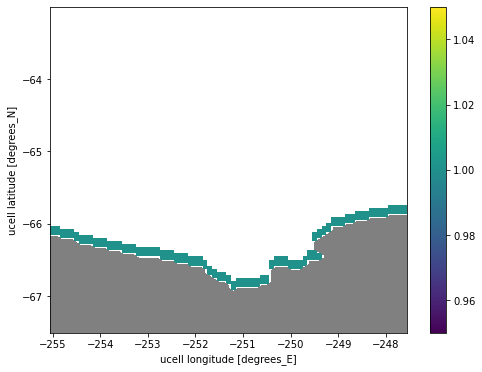

In [57]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U0m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=1)] = np.nan
shelf_mask = shelf_mask+0
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

plt.figure(figsize=(8,6))
region_mask.plot()
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [58]:
#apply the mask of shelf MEAN
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.mean('xu_ocean').mean('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.mean('xu_ocean').mean('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-9.386173491989227
-7.807615922317264


In [59]:
#apply the mask of shelf SUM
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.sum('xu_ocean').sum('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.sum('xu_ocean').sum('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-2055.289934775079
-1684.7458704362832


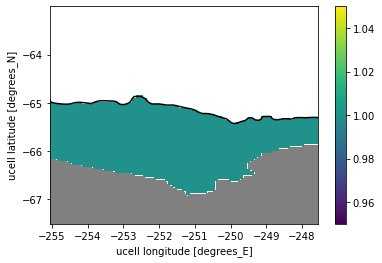

In [60]:

# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U10003000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=1)] = np.nan
shelf_mask = shelf_mask+0
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [61]:
#apply the mask of shelf MEAN
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.mean('xu_ocean').mean('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.mean('xu_ocean').mean('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-1.6313375920091686
-1.433889954485904


In [62]:
#apply the mask of shelf SUM
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.sum('xu_ocean').sum('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.sum('xu_ocean').sum('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-1303.3311574777367
-1202.3038168959702
